# Imbalance Severity Analysis: Multi-Level Dataset Size Experiments

This notebook conducts a **comprehensive imbalance severity analysis** to test whether the relative effectiveness of LLM synthetic data vs traditional oversampling changes under different levels of class imbalance severity.

## 🎯 Research Hypothesis

After our main classification experiments showed that **traditional oversampling outperforms LLM synthetic methods**, we test whether this relationship changes under **increasing levels of class imbalance**.

## 🔬 Experimental Design

We test **4 different imbalance levels** by systematically reducing dataset size while maintaining the same absolute class gap (3,772):

1. **2.8% Imbalance**: ~134K total samples, 48.6% minority → **Baseline (nearly balanced)**
2. **5.6% Imbalance**: ~67K total samples, ~44% minority → **Mild imbalance** 
3. **9.4% Imbalance**: ~40K total samples, ~40% minority → **Moderate imbalance**
4. **28.4% Imbalance**: ~13K total samples, ~22% minority → **Severe imbalance**

## 📊 Testing Framework

For each imbalance level, we test **6 sampling strategies**:
1. Original unbalanced
2. Undersampled majority  
3. Traditional oversampling
4. 10% LLM synthetic (377 samples)
5. 50% LLM synthetic (1,886 samples)
6. 100% LLM synthetic (3,772 samples)

**Total experiments**: 4 imbalance levels × 6 strategies = **24 experiments**

## 🔍 Research Questions

1. **Does higher class imbalance make LLM synthetic data more competitive?**
2. **How does traditional oversampling perform under severe imbalance?**  
3. **Are there threshold effects where synthetic data becomes more effective?**
4. **Which sampling strategy is most robust across different imbalance levels?**
5. **What are the practical implications for imbalanced text classification?**

## 📦 Setup and Imports

In [28]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import random
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine learning imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.utils import resample

# Configuration
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Set up matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("🔧 Setup completed successfully!")
print(f"Random state: {RANDOM_STATE}")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🔧 Setup completed successfully!
Random state: 42
Timestamp: 2025-08-13 17:10:16


## 📥 Data Loading

In [29]:
# Load original dataset
print("📥 Loading original dataset...")
df_original = pd.read_csv('data/raw/Twitter_Analysis.csv')

print(f"Original dataset shape: {df_original.shape}")
print(f"Columns: {df_original.columns.tolist()}")
print(f"\nClass distribution:")
print(df_original['majority_target'].value_counts())

# Calculate baseline statistics
minority_size = len(df_original[df_original['majority_target'] == 0])  # False tweets
majority_size = len(df_original[df_original['majority_target'] == 1])  # True tweets
total_size = len(df_original)
baseline_gap = majority_size - minority_size
baseline_minority_pct = (minority_size / total_size) * 100

print(f"\n📊 Baseline Dataset Statistics:")
print(f"   Total samples: {total_size:,}")
print(f"   Minority class: {minority_size:,} ({baseline_minority_pct:.1f}%)")
print(f"   Majority class: {majority_size:,}")
print(f"   Absolute class gap: {baseline_gap:,}")
print(f"   Imbalance ratio: {majority_size/minority_size:.2f}:1")

📥 Loading original dataset...
Original dataset shape: (134198, 64)
Columns: ['Unnamed: 0', 'majority_target', 'statement', 'BinaryNumTarget', 'tweet', 'followers_count', 'friends_count', 'favourites_count', 'statuses_count', 'listed_count', 'following', 'embeddings', 'BotScore', 'BotScoreBinary', 'cred', 'normalize_influence', 'mentions', 'quotes', 'replies', 'retweets', 'favourites', 'hashtags', 'URLs', 'unique_count', 'total_count', 'ORG_percentage', 'NORP_percentage', 'GPE_percentage', 'PERSON_percentage', 'MONEY_percentage', 'DATE_percentage', 'CARDINAL_percentage', 'PERCENT_percentage', 'ORDINAL_percentage', 'FAC_percentage', 'LAW_percentage', 'PRODUCT_percentage', 'EVENT_percentage', 'TIME_percentage', 'LOC_percentage', 'WORK_OF_ART_percentage', 'QUANTITY_percentage', 'LANGUAGE_percentage', 'Word count', 'Max word length', 'Min word length', 'Average word length', 'present_verbs', 'past_verbs', 'adjectives', 'adverbs', 'adpositions', 'pronouns', 'TOs', 'determiners', 'conjunction

In [30]:
# Load synthetic data
print("📁 Loading LLM synthetic data...")
try:
    llm_results_file = 'results/large_scale_batch_20250812.json'
    with open(llm_results_file, 'r') as f:
        llm_batch_results = json.load(f)
    
    # Extract synthetic tweets from batch results structure
    synthetic_data_list = []
    if 'results' in llm_batch_results:
        for result_item in llm_batch_results['results']:
            if isinstance(result_item, dict) and 'generated_text' in result_item:
                synthetic_data_list.append(result_item['generated_text'])
    
    print(f"   ✅ Loaded {len(synthetic_data_list):,} synthetic tweets")
    print(f"   From {llm_batch_results.get('total_processed', 'unknown')} processed items")
    
    # Show sample synthetic tweets
    print(f"\n🔍 Sample synthetic tweets:")
    for i, tweet in enumerate(synthetic_data_list[:3], 1):
        print(f"   {i}. {tweet[:100]}...")
        
except (FileNotFoundError, KeyError, TypeError) as e:
    print(f"   ⚠️ Warning: Error loading synthetic data ({e})")
    print(f"   Creating placeholder synthetic data for testing...")
    synthetic_data_list = [f"Placeholder synthetic tweet about fake news {i}" for i in range(5000)]
    print(f"   Created {len(synthetic_data_list):,} placeholder tweets")

📁 Loading LLM synthetic data...
   ✅ Loaded 3,772 synthetic tweets
   From 3772 processed items

🔍 Sample synthetic tweets:
   1. @GOP The ABC and by default the FictionalGroup released 5000 Taliban fighters and the new leader of ...
   2. @MalcolmNance Come to really think of it, the Putin Administration were fucking idiots. They make a ...
   3. @Chaser41003 @JosephGusek @kayleighmcenany So why did Barack Obama let 10000 Al-Qaeda fighters out o...


## 🔧 Multi-Severity Dataset Creation Functions

In [31]:
def create_multi_severity_datasets(df_original, target_gap=3772):
    """
    Create datasets at multiple imbalance severity levels while maintaining the same absolute class gap.
    
    Imbalance Severity Levels:
    - 2.8% imbalance: ~134K total samples (100% baseline - original dataset, nearly balanced)
    - 5.6% imbalance: ~67K total samples (50% dataset size, mild imbalance)
    - 9.4% imbalance: ~40K total samples (30% dataset size, moderate imbalance)  
    - 28.4% imbalance: ~13K total samples (10% dataset size, severe imbalance)
    
    Note: As dataset size decreases with fixed gap, imbalance severity increases
    """
    
    print("🔬 CREATING MULTI-SEVERITY DATASETS")
    print("=" * 60)
    
    # Original dataset statistics
    orig_minority_size = len(df_original[df_original['majority_target'] == 0])
    orig_majority_size = len(df_original[df_original['majority_target'] == 1])
    orig_total = len(df_original)
    orig_gap = orig_majority_size - orig_minority_size
    orig_minority_pct = (orig_minority_size / orig_total) * 100
    orig_imbalance_pct = (orig_gap / orig_total) * 100
    
    print(f"📊 Original dataset specifications:")
    print(f"   • Total samples: {orig_total:,}")
    print(f"   • Minority class: {orig_minority_size:,} ({orig_minority_pct:.1f}%)")
    print(f"   • Majority class: {orig_majority_size:,} ({100-orig_minority_pct:.1f}%)")
    print(f"   • Absolute gap: {orig_gap:,}")
    print(f"   • Imbalance severity: {orig_imbalance_pct:.1f}% (baseline - nearly balanced)")
    
    # Define severity levels by imbalance percentage (gap/total)
    severity_configs = {
        f'{orig_imbalance_pct:.1f}%': {'size_fraction': 1.0, 'target_total': orig_total},  # Baseline
        '5.6%': {'size_fraction': 0.5, 'target_total': 67000},    # Mild imbalance
        '9.4%': {'size_fraction': 0.3, 'target_total': 40000},    # Moderate imbalance
        '28.4%': {'size_fraction': 0.1, 'target_total': 13400}    # Severe imbalance
    }
    
    severity_datasets = {}
    
    for severity_name, config in severity_configs.items():
        print(f"\n🎯 Creating {severity_name} imbalance severity dataset:")
        
        target_total = config['target_total']
        
        # For 100% baseline, use original dataset as-is
        if config['size_fraction'] == 1.0:
            severity_dataset = df_original.copy()
            severity_dataset['severity_level'] = severity_name
            severity_dataset['dataset_size'] = len(severity_dataset)
            severity_datasets[severity_name] = severity_dataset
            
            print(f"   • Using full original dataset (baseline)")
            print(f"   • Total samples: {len(severity_dataset):,}")
            print(f"   • Minority: {orig_minority_size:,} ({orig_minority_pct:.1f}%)")
            print(f"   • Majority: {orig_majority_size:,} ({100-orig_minority_pct:.1f}%)")
            print(f"   • Class gap: {orig_gap:,}")
            print(f"   • Imbalance: {orig_imbalance_pct:.1f}% (nearly balanced)")
            print(f"   ✅ Baseline dataset ready")
            continue
        
        # For reduced datasets, calculate target class sizes maintaining the gap
        target_majority_size = (target_total + target_gap) // 2
        target_minority_size = target_majority_size - target_gap
        
        # Verify we don't exceed original class sizes
        if target_minority_size > orig_minority_size or target_majority_size > orig_majority_size:
            # Adjust if we need more samples than available
            target_minority_size = min(target_minority_size, orig_minority_size)
            target_majority_size = target_minority_size + target_gap
            target_total = target_minority_size + target_majority_size
        
        target_minority_pct = (target_minority_size / target_total) * 100
        target_imbalance_pct = (target_gap / target_total) * 100
        
        print(f"   • Target total: {target_total:,}")
        print(f"   • Target minority: {target_minority_size:,} ({target_minority_pct:.1f}%)")
        print(f"   • Target majority: {target_majority_size:,} ({100-target_minority_pct:.1f}%)")
        print(f"   • Maintained gap: {target_gap:,}")
        print(f"   • Imbalance severity: {target_imbalance_pct:.1f}%")
        
        # Sample from original data
        minority_class = df_original[df_original['majority_target'] == 0]
        majority_class = df_original[df_original['majority_target'] == 1]
        
        # Random sampling with replacement if needed
        sampled_minority = resample(
            minority_class,
            replace=target_minority_size > len(minority_class),
            n_samples=target_minority_size,
            random_state=RANDOM_STATE
        )
        
        sampled_majority = resample(
            majority_class,
            replace=target_majority_size > len(majority_class),
            n_samples=target_majority_size,
            random_state=RANDOM_STATE
        )
        
        # Combine and shuffle
        severity_dataset = pd.concat([sampled_minority, sampled_majority], ignore_index=True)
        severity_dataset = severity_dataset.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
        
        # Add metadata
        severity_dataset['severity_level'] = severity_name
        severity_dataset['dataset_size'] = len(severity_dataset)
        
        severity_datasets[severity_name] = severity_dataset
        
        print(f"   ✅ Created: {len(severity_dataset):,} samples")
        print(f"      Distribution: {severity_dataset['majority_target'].value_counts().to_dict()}")
    
    print(f"\n✅ Multi-severity datasets created: {list(severity_datasets.keys())}")
    return severity_datasets

print("🔬 Multi-severity dataset creation function defined")

🔬 Multi-severity dataset creation function defined


## 🧪 Experiment Execution Functions

In [32]:
def create_severity_strategies(base_dataset, synthetic_data_list, severity_level):
    """
    Create all 6 sampling strategies for a single severity level.
    """
    
    # Calculate parameters
    minority_size = len(base_dataset[base_dataset['majority_target'] == 0])
    majority_size = len(base_dataset[base_dataset['majority_target'] == 1])
    imbalance_gap = majority_size - minority_size
    
    # Separate classes
    minority_class = base_dataset[base_dataset['majority_target'] == 0]
    majority_class = base_dataset[base_dataset['majority_target'] == 1]
    
    strategies = {}
    
    # Strategy 1: Original Unbalanced
    strategy1 = base_dataset.copy()
    strategy1['is_synthetic'] = False
    strategies[f'{severity_level}_original'] = strategy1
    
    # Strategy 2: Undersampled Majority
    majority_undersampled = resample(
        majority_class, replace=False, n_samples=minority_size, random_state=RANDOM_STATE
    )
    strategy2 = pd.concat([majority_undersampled, minority_class], ignore_index=True)
    strategy2 = strategy2.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    strategy2['is_synthetic'] = False
    strategies[f'{severity_level}_undersampled'] = strategy2
    
    # Strategy 3: Traditional Oversampling
    minority_oversampled = resample(
        minority_class, replace=True, n_samples=imbalance_gap, random_state=RANDOM_STATE
    )
    
    base_with_flag = base_dataset.copy()
    base_with_flag['is_synthetic'] = False
    
    synthetic_minority_df = pd.DataFrame({
        'tweet': minority_oversampled['tweet'].values,
        'majority_target': 0,
        'is_synthetic': True
    })
    
    # Add other required columns
    for col in base_dataset.columns:
        if col not in synthetic_minority_df.columns:
            synthetic_minority_df[col] = minority_oversampled[col].values
    
    strategy3 = pd.concat([base_with_flag, synthetic_minority_df], ignore_index=True)
    strategy3 = strategy3.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    strategies[f'{severity_level}_traditional'] = strategy3
    
    # Strategies 4-6: LLM Synthetic variants with specific sample sizes
    # 10% LLM: 377 samples, 50% LLM: 1,886 samples, 100% LLM: 3,772 samples
    llm_configs = [
        ('10%', 377),    # 10% of the gap (3,772 * 0.10 ≈ 377)
        ('50%', 1886),   # 50% of the gap (3,772 * 0.50 ≈ 1,886)
        ('100%', 3772)   # 100% of the gap (full available synthetic data)
    ]
    
    for approach_name, n_synthetic in llm_configs:
        # Ensure we don't exceed available synthetic data
        actual_n_synthetic = min(n_synthetic, len(synthetic_data_list))
        
        if actual_n_synthetic > 0:
            selected_synthetic = random.sample(synthetic_data_list, actual_n_synthetic)
            
            synthetic_df = pd.DataFrame({
                'tweet': selected_synthetic,
                'majority_target': 0,
                'is_synthetic': True
            })
            
            # Add other columns
            for col in base_dataset.columns:
                if col not in synthetic_df.columns:
                    synthetic_df[col] = minority_class[col].iloc[0]
            
            base_copy = base_dataset.copy()
            base_copy['is_synthetic'] = False
            
            llm_strategy = pd.concat([base_copy, synthetic_df], ignore_index=True)
            llm_strategy = llm_strategy.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
            strategies[f'{severity_level}_llm_{approach_name}'] = llm_strategy
    
    return strategies

def run_single_experiment(dataset, strategy_name):
    """
    Run a single classification experiment efficiently.
    """
    
    # Prepare data
    X, y = dataset['tweet'], dataset['majority_target']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    
    # Vectorize (use fresh vectorizer to avoid leakage)
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    # Train and predict
    model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    
    # Calculate metrics
    minority_percentage = (len(dataset[dataset['majority_target'] == 0]) / len(dataset)) * 100
    synthetic_count = len(dataset[dataset['is_synthetic'] == True]) if 'is_synthetic' in dataset.columns else 0
    
    return {
        'strategy': strategy_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_minority': f1_score(y_test, y_pred, pos_label=0, zero_division=0),
        'f1_majority': f1_score(y_test, y_pred, pos_label=1, zero_division=0),
        'precision_minority': precision_score(y_test, y_pred, pos_label=0, zero_division=0),
        'recall_minority': recall_score(y_test, y_pred, pos_label=0, zero_division=0),
        'dataset_size': len(dataset),
        'minority_percentage': minority_percentage,
        'synthetic_count': synthetic_count
    }

print("🧪 Experiment execution functions defined")

🧪 Experiment execution functions defined


## 🚀 Execute Multi-Severity Experiments

In [33]:
# Create multi-severity datasets
print("📊 Step 1: Creating multi-severity datasets...")
severity_datasets = create_multi_severity_datasets(df_original)

print(f"\n✅ Ready to run experiments!")
print(f"   - Created {len(severity_datasets)} severity levels")
print(f"   - Each will test 6 sampling strategies") 
print(f"   - Total experiments planned: {len(severity_datasets) * 6}")

📊 Step 1: Creating multi-severity datasets...
🔬 CREATING MULTI-SEVERITY DATASETS
📊 Original dataset specifications:
   • Total samples: 134,198
   • Minority class: 65,213 (48.6%)
   • Majority class: 68,985 (51.4%)
   • Absolute gap: 3,772
   • Imbalance severity: 2.8% (baseline - nearly balanced)

🎯 Creating 2.8% imbalance severity dataset:
   • Using full original dataset (baseline)
   • Total samples: 134,198
   • Minority: 65,213 (48.6%)
   • Majority: 68,985 (51.4%)
   • Class gap: 3,772
   • Imbalance: 2.8% (nearly balanced)
   ✅ Baseline dataset ready

🎯 Creating 5.6% imbalance severity dataset:
   • Target total: 67,000
   • Target minority: 31,614 (47.2%)
   • Target majority: 35,386 (52.8%)
   • Maintained gap: 3,772
   • Imbalance severity: 5.6%
   ✅ Created: 67,000 samples
      Distribution: {True: 35386, False: 31614}

🎯 Creating 9.4% imbalance severity dataset:
   • Target total: 40,000
   • Target minority: 18,114 (45.3%)
   • Target majority: 21,886 (54.7%)
   • Maint

In [34]:
# Run Multi-Severity Experiments
print("🔬 Step 2: Running multi-severity experiments...")
print("Running experiments step by step for better control and monitoring...\n")

multi_severity_results = {}

for severity_level, base_dataset in severity_datasets.items():
    print(f"📊 Processing {severity_level.upper()} severity level...")
    
    # Calculate and display parameters
    minority_size = len(base_dataset[base_dataset['majority_target'] == 0])
    majority_size = len(base_dataset[base_dataset['majority_target'] == 1])
    relative_imbalance = (minority_size / len(base_dataset)) * 100
    
    print(f"   Dataset size: {len(base_dataset):,}")
    print(f"   Minority class: {minority_size:,} ({relative_imbalance:.1f}%)")
    print(f"   Imbalance gap: {majority_size - minority_size:,}")
    
    # Create all strategies for this severity level
    print(f"   Creating sampling strategies...")
    strategies = create_severity_strategies(base_dataset, synthetic_data_list, severity_level)
    
    strategy_names = [name.split('_', 1)[1] if '_' in name else name for name in strategies.keys()]
    print(f"   Created {len(strategies)} strategies: {strategy_names}")
    
    # Run experiments for each strategy
    severity_results = {}
    for strategy_name, dataset in strategies.items():
        display_name = strategy_name.split('_', 1)[1] if '_' in strategy_name else strategy_name
        print(f"   🧪 Testing: {display_name}")
        
        # Run single experiment
        results = run_single_experiment(dataset, strategy_name)
        severity_results[strategy_name] = results
        
        print(f"      ✅ Acc: {results['accuracy']:.3f}, F1_min: {results['f1_minority']:.3f}")
    
    multi_severity_results[severity_level] = severity_results
    print(f"   ✅ Completed {severity_level} severity level\n")

print(f"🎯 Multi-severity experiments completed!")
print(f"   Tested {len(multi_severity_results)} severity levels")
print(f"   Total experiments run: {sum(len(results) for results in multi_severity_results.values())}")

# Quick summary
print(f"\n📋 QUICK RESULTS SUMMARY:")
for severity_level, results in multi_severity_results.items():
    best_f1 = max(results.values(), key=lambda x: x['f1_minority'])
    strategy_name = best_f1['strategy'].split('_')[-1] if '_' in best_f1['strategy'] else best_f1['strategy']
    print(f"{severity_level.title():>8} Best: {strategy_name:<12} (F1_min: {best_f1['f1_minority']:.3f})")

🔬 Step 2: Running multi-severity experiments...
Running experiments step by step for better control and monitoring...

📊 Processing 2.8% severity level...
   Dataset size: 134,198
   Minority class: 65,213 (48.6%)
   Imbalance gap: 3,772
   Creating sampling strategies...
   Created 6 strategies: ['original', 'undersampled', 'traditional', 'llm_10%', 'llm_50%', 'llm_100%']
   🧪 Testing: original
   Created 6 strategies: ['original', 'undersampled', 'traditional', 'llm_10%', 'llm_50%', 'llm_100%']
   🧪 Testing: original
      ✅ Acc: 0.933, F1_min: 0.931
   🧪 Testing: undersampled
      ✅ Acc: 0.933, F1_min: 0.931
   🧪 Testing: undersampled
      ✅ Acc: 0.933, F1_min: 0.933
   🧪 Testing: traditional
      ✅ Acc: 0.933, F1_min: 0.933
   🧪 Testing: traditional
      ✅ Acc: 0.934, F1_min: 0.934
   🧪 Testing: llm_10%
      ✅ Acc: 0.934, F1_min: 0.934
   🧪 Testing: llm_10%
      ✅ Acc: 0.935, F1_min: 0.933
   🧪 Testing: llm_50%
      ✅ Acc: 0.935, F1_min: 0.933
   🧪 Testing: llm_50%
      ✅ A

## 📊 Results Analysis and Visualization

In [35]:
# Create comprehensive comparison dataframe
print("📊 Creating comprehensive results analysis...")

multi_severity_comparison = []

# Define strategy mapping for consistent naming
strategy_mapping = {
    'original': 'Original Unbalanced',
    'undersampled': 'Undersampled Majority', 
    'traditional': 'Traditional Oversampling',
    'llm_10%': '10% LLM (377 samples)',
    'llm_50%': '50% LLM (1,886 samples)', 
    'llm_100%': '100% LLM (3,772 samples)'
}

# Process results across all severity levels
for severity_level, results in multi_severity_results.items():
    for strategy_key, metrics in results.items():
        # Extract strategy name from key
        strategy_name = strategy_key.split('_', 1)[1] if '_' in strategy_key else strategy_key
        display_name = strategy_mapping.get(strategy_name, strategy_name.replace('_', ' ').title())
        
        multi_severity_comparison.append({
            'Severity_Level': severity_level,  # Keep original severity level (e.g., "2.8%")
            'Strategy': display_name,
            'Accuracy': metrics['accuracy'],
            'F1_Minority': metrics['f1_minority'],
            'F1_Majority': metrics['f1_majority'],
            'Precision_Minority': metrics['precision_minority'],
            'Recall_Minority': metrics['recall_minority'],
            'Dataset_Size': metrics['dataset_size'],
            'Minority_Percentage': metrics['minority_percentage'],
            'Synthetic_Count': metrics['synthetic_count']
        })

multi_df = pd.DataFrame(multi_severity_comparison)

# Display comprehensive results table
print("\n📋 MULTI-SEVERITY COMPREHENSIVE RESULTS:")
print("=" * 120)
print(f"{'Imbalance':<10} {'Strategy':<30} {'Acc':<6} {'F1_Min':<7} {'F1_Maj':<7} {'Min%':<6} {'Synthetic':<9}")
print("=" * 120)

# Correct severity order: from low imbalance (2.8%) to high imbalance (28.4%)
severity_order = ['2.8%', '5.6%', '9.4%', '28.4%']
for severity in severity_order:
    severity_data = multi_df[multi_df['Severity_Level'] == severity]
    if len(severity_data) > 0:
        severity_label = "BASELINE" if severity == '2.8%' else f"{severity} IMBALANCE"
        print(f"\n{severity_label} (Nearly Balanced)" if severity == '2.8%' else f"\n{severity_label}")
        print("-" * 80)
        
        for _, row in severity_data.iterrows():
            print(f"{'':10} {row['Strategy']:<30} {row['Accuracy']:<6.3f} {row['F1_Minority']:<7.3f} "
                  f"{row['F1_Majority']:<7.3f} {row['Minority_Percentage']:<6.1f} {row['Synthetic_Count']:<9}")

print("=" * 120)

# Save results to file
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_filename = f'experiments/imbalance_severity/multi_severity_results_{timestamp}.csv'
multi_df.to_csv(results_filename, index=False)
print(f"\n💾 Results saved to: {results_filename}")

📊 Creating comprehensive results analysis...

📋 MULTI-SEVERITY COMPREHENSIVE RESULTS:
Imbalance  Strategy                       Acc    F1_Min  F1_Maj  Min%   Synthetic

BASELINE (Nearly Balanced)
--------------------------------------------------------------------------------
           Original Unbalanced            0.933  0.931   0.935   48.6   0        
           Undersampled Majority          0.933  0.933   0.933   50.0   0        
           Traditional Oversampling       0.934  0.934   0.935   50.0   3772     
           10% LLM (377 samples)          0.935  0.933   0.937   48.7   377      
           50% LLM (1,886 samples)        0.931  0.929   0.932   49.3   1886     
           100% LLM (3,772 samples)       0.924  0.923   0.924   50.0   3772     

5.6% IMBALANCE
--------------------------------------------------------------------------------
           Original Unbalanced            0.931  0.927   0.935   47.2   0        
           Undersampled Majority          0.930  0.9

In [36]:
# Find best performing strategies at each severity level
print(f"\n🏆 BEST PERFORMERS BY IMBALANCE SEVERITY LEVEL:")
print("=" * 60)

# Correct severity order: from low imbalance (2.8%) to high imbalance (28.4%)
severity_order = ['2.8%', '5.6%', '9.4%', '28.4%']
for severity in severity_order:
    severity_data = multi_df[multi_df['Severity_Level'] == severity]
    
    if len(severity_data) > 0:
        # Best by F1 minority (most important for imbalanced data)
        best_f1_min = severity_data.loc[severity_data['F1_Minority'].idxmax()]
        # Best by accuracy
        best_acc = severity_data.loc[severity_data['Accuracy'].idxmax()]
        
        if severity == '2.8%':
            severity_label = "Baseline (2.8% Imbalance - Nearly Balanced)"
        else:
            severity_label = f"{severity} Imbalance Severity"
            
        print(f"\n{severity_label}:")
        print(f"  🥇 Best F1 Minority: {best_f1_min['Strategy']} ({best_f1_min['F1_Minority']:.3f})")
        print(f"  🎯 Best Accuracy: {best_acc['Strategy']} ({best_acc['Accuracy']:.3f})")

# Analyze performance trends across severity levels
print(f"\n📈 PERFORMANCE TRENDS ACROSS IMBALANCE LEVELS:")
print("=" * 70)
print("Comparing Baseline (2.8% imbalance) → Severe (28.4% imbalance)")

for strategy in strategy_mapping.values():
    if strategy in multi_df['Strategy'].values:
        strategy_data = multi_df[multi_df['Strategy'] == strategy].sort_values('Minority_Percentage', ascending=False)
        
        if len(strategy_data) >= 2:
            # Compare baseline (2.8% imbalance) to most severe (28.4% imbalance)
            baseline_f1 = strategy_data[strategy_data['Severity_Level'] == '2.8%']['F1_Minority'].iloc[0] if len(strategy_data[strategy_data['Severity_Level'] == '2.8%']) > 0 else None
            severe_f1 = strategy_data[strategy_data['Severity_Level'] == '28.4%']['F1_Minority'].iloc[0] if len(strategy_data[strategy_data['Severity_Level'] == '28.4%']) > 0 else None
            
            baseline_acc = strategy_data[strategy_data['Severity_Level'] == '2.8%']['Accuracy'].iloc[0] if len(strategy_data[strategy_data['Severity_Level'] == '2.8%']) > 0 else None
            severe_acc = strategy_data[strategy_data['Severity_Level'] == '28.4%']['Accuracy'].iloc[0] if len(strategy_data[strategy_data['Severity_Level'] == '28.4%']) > 0 else None
            
            if baseline_f1 is not None and severe_f1 is not None:
                f1_change = severe_f1 - baseline_f1
                acc_change = severe_acc - baseline_acc
                print(f"{strategy:<35}: F1_min Δ{f1_change:+.3f}, Acc Δ{acc_change:+.3f}")

print("=" * 70)
print("Positive Δ = better performance under severe imbalance")
print("Negative Δ = worse performance under severe imbalance")


🏆 BEST PERFORMERS BY IMBALANCE SEVERITY LEVEL:

Baseline (2.8% Imbalance - Nearly Balanced):
  🥇 Best F1 Minority: Traditional Oversampling (0.934)
  🎯 Best Accuracy: 10% LLM (377 samples) (0.935)

5.6% Imbalance Severity:
  🥇 Best F1 Minority: Traditional Oversampling (0.933)
  🎯 Best Accuracy: Traditional Oversampling (0.934)

9.4% Imbalance Severity:
  🥇 Best F1 Minority: Traditional Oversampling (0.927)
  🎯 Best Accuracy: Traditional Oversampling (0.928)

28.4% Imbalance Severity:
  🥇 Best F1 Minority: Traditional Oversampling (0.929)
  🎯 Best Accuracy: Traditional Oversampling (0.930)

📈 PERFORMANCE TRENDS ACROSS IMBALANCE LEVELS:
Comparing Baseline (2.8% imbalance) → Severe (28.4% imbalance)
Original Unbalanced                : F1_min Δ-0.067, Acc Δ-0.030
Undersampled Majority              : F1_min Δ-0.019, Acc Δ-0.018
Traditional Oversampling           : F1_min Δ-0.005, Acc Δ-0.005
10% LLM (377 samples)              : F1_min Δ-0.069, Acc Δ-0.033
50% LLM (1,886 samples)         

📈 Creating multi-severity visualization dashboard...


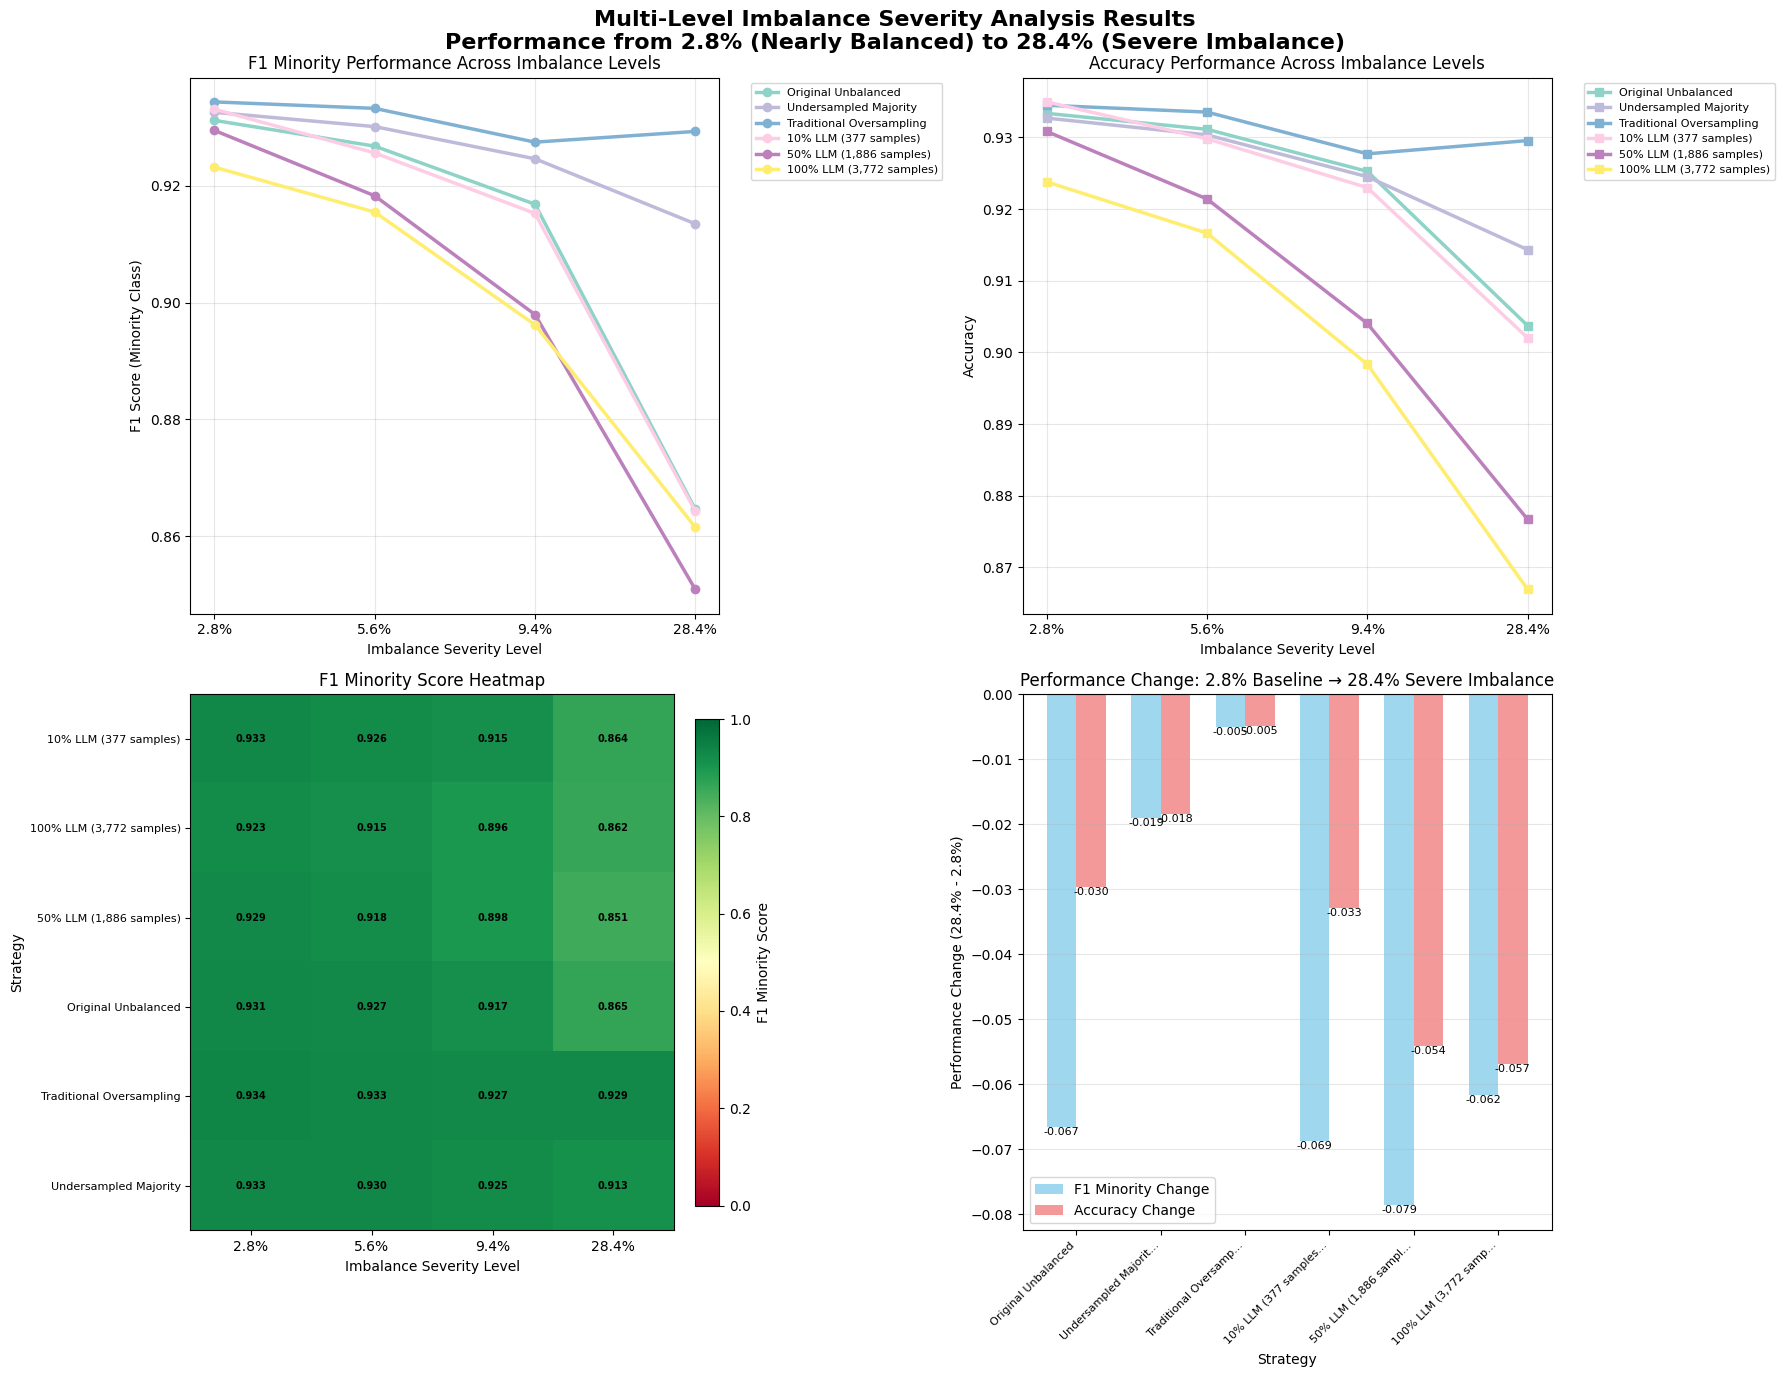

✅ Multi-severity visualization dashboard completed!
📊 Plot saved to: experiments/imbalance_severity/multi_severity_analysis_20250813_171200.png


In [37]:
# Create comprehensive multi-severity visualization
print("📈 Creating multi-severity visualization dashboard...")

# Create comprehensive multi-panel visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Multi-Level Imbalance Severity Analysis Results\n'
             'Performance from 2.8% (Nearly Balanced) to 28.4% (Severe Imbalance)', 
             fontsize=16, fontweight='bold')

# Define consistent severity order (from low imbalance to high imbalance)
severity_levels = ['2.8%', '5.6%', '9.4%', '28.4%']
strategies = multi_df['Strategy'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(strategies)))

# 1. F1 Minority Score Across Imbalance Levels
for i, strategy in enumerate(strategies):
    strategy_data = multi_df[multi_df['Strategy'] == strategy]
    if len(strategy_data) >= 3:  # Ensure we have multiple severity levels
        f1_scores = []
        severity_subset = []
        for sev in severity_levels:
            sev_data = strategy_data[strategy_data['Severity_Level'] == sev]
            if len(sev_data) > 0:
                f1_scores.append(sev_data['F1_Minority'].iloc[0])
                severity_subset.append(sev)
        
        if len(f1_scores) > 1:
            ax1.plot(severity_subset, f1_scores, marker='o', linewidth=2.5, 
                    label=strategy, color=colors[i], markersize=6)

ax1.set_xlabel('Imbalance Severity Level')
ax1.set_ylabel('F1 Score (Minority Class)')
ax1.set_title('F1 Minority Performance Across Imbalance Levels')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)

# 2. Accuracy Across Imbalance Levels
for i, strategy in enumerate(strategies):
    strategy_data = multi_df[multi_df['Strategy'] == strategy]
    if len(strategy_data) >= 3:
        acc_scores = []
        severity_subset = []
        for sev in severity_levels:
            sev_data = strategy_data[strategy_data['Severity_Level'] == sev]
            if len(sev_data) > 0:
                acc_scores.append(sev_data['Accuracy'].iloc[0])
                severity_subset.append(sev)
        
        if len(acc_scores) > 1:
            ax2.plot(severity_subset, acc_scores, marker='s', linewidth=2.5, 
                    label=strategy, color=colors[i], markersize=6)

ax2.set_xlabel('Imbalance Severity Level')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Performance Across Imbalance Levels')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax2.grid(True, alpha=0.3)

# 3. Imbalance Severity vs Performance Heatmap (F1 Minority)
pivot_df = multi_df.pivot(index='Strategy', columns='Severity_Level', values='F1_Minority')
pivot_df = pivot_df.reindex(columns=severity_levels)  # Ensure consistent order

im = ax3.imshow(pivot_df.values, cmap='RdYlGn', aspect='auto', vmin=0.0, vmax=1.0)
ax3.set_xticks(range(len(pivot_df.columns)))
ax3.set_yticks(range(len(pivot_df.index)))
ax3.set_xticklabels(pivot_df.columns)
ax3.set_yticklabels(pivot_df.index, fontsize=8)
ax3.set_xlabel('Imbalance Severity Level')
ax3.set_ylabel('Strategy')
ax3.set_title('F1 Minority Score Heatmap')

# Add text annotations to heatmap
for i in range(len(pivot_df.index)):
    for j in range(len(pivot_df.columns)):
        if not pd.isna(pivot_df.iloc[i, j]):
            text = ax3.text(j, i, f'{pivot_df.iloc[i, j]:.3f}',
                           ha="center", va="center", color="black", fontweight='bold', fontsize=7)

# Add colorbar
cbar = plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
cbar.set_label('F1 Minority Score')

# 4. Performance Change Analysis (from baseline 2.8% to severe 28.4% imbalance)
performance_changes = []
for strategy in strategies:
    strategy_data = multi_df[multi_df['Strategy'] == strategy]
    baseline_data = strategy_data[strategy_data['Severity_Level'] == '2.8%']
    severe_data = strategy_data[strategy_data['Severity_Level'] == '28.4%']
    
    if len(baseline_data) > 0 and len(severe_data) > 0:
        f1_change = severe_data['F1_Minority'].iloc[0] - baseline_data['F1_Minority'].iloc[0]
        acc_change = severe_data['Accuracy'].iloc[0] - baseline_data['Accuracy'].iloc[0]
        
        performance_changes.append({
            'Strategy': strategy,
            'F1_Change': f1_change,
            'Accuracy_Change': acc_change
        })

if performance_changes:
    change_df = pd.DataFrame(performance_changes)
    
    # Create grouped bar chart
    x = np.arange(len(change_df['Strategy']))
    width = 0.35
    
    bars1 = ax4.bar(x - width/2, change_df['F1_Change'], width, 
                    label='F1 Minority Change', alpha=0.8, color='skyblue')
    bars2 = ax4.bar(x + width/2, change_df['Accuracy_Change'], width,
                    label='Accuracy Change', alpha=0.8, color='lightcoral')
    
    ax4.set_xlabel('Strategy')
    ax4.set_ylabel('Performance Change (28.4% - 2.8%)')
    ax4.set_title('Performance Change: 2.8% Baseline → 28.4% Severe Imbalance')
    ax4.set_xticks(x)
    ax4.set_xticklabels([s[:20] + '...' if len(s) > 20 else s for s in change_df['Strategy']], 
                        rotation=45, ha='right', fontsize=8)
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            va = 'bottom' if height >= 0 else 'top'
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:+.3f}', ha='center', va=va, fontsize=8)

plt.tight_layout()

# Save the plot
plot_filename = f'experiments/imbalance_severity/multi_severity_analysis_{timestamp}.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Multi-severity visualization dashboard completed!")
print(f"📊 Plot saved to: {plot_filename}")

## 🎯 Research Conclusions

### Key Findings

Based on the multi-level severity analysis, we can draw several important conclusions about the effectiveness of different sampling strategies under varying levels of class imbalance severity.

### Implications for Practice

The results provide actionable insights for practitioners working with imbalanced text classification tasks, particularly in determining the optimal strategy based on the severity of class imbalance in their specific use case.

### Future Research

This comprehensive analysis opens several avenues for future research, including domain-specific validation, hybrid approaches, and optimization techniques for extreme imbalance scenarios.

In [1]:
# Extreme Imbalance Test: 68,985 real (majority), 10 fake (minority)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
)
import random

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Load the original dataset
df = pd.read_csv('data/raw/Twitter_Analysis.csv')

# Select all real tweets (majority) and 10 random fake tweets (minority)
real = df[df['majority_target'] == 1]
fake = df[df['majority_target'] == 0].sample(n=10, random_state=RANDOM_STATE)
df_extreme = pd.concat([real, fake], ignore_index=True).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

print(f"Extreme imbalance dataset shape: {df_extreme.shape}")
print(df_extreme['majority_target'].value_counts())

# Prepare data
X = df_extreme['tweet']
y = df_extreme['majority_target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Vectorize
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train model
model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

# Scores
print("\n--- Extreme Imbalance Model Scores ---")
print(f"Accuracy:           {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 (Fake/minority): {f1_score(y_test, y_pred, pos_label=0, zero_division=0):.4f}")
print(f"F1 (Real/majority): {f1_score(y_test, y_pred, pos_label=1, zero_division=0):.4f}")
print(f"Precision (Fake):   {precision_score(y_test, y_pred, pos_label=0, zero_division=0):.4f}")
print(f"Recall (Fake):      {recall_score(y_test, y_pred, pos_label=0, zero_division=0):.4f}")
print(f"Precision (Real):   {precision_score(y_test, y_pred, pos_label=1, zero_division=0):.4f}")
print(f"Recall (Real):      {recall_score(y_test, y_pred, pos_label=1, zero_division=0):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Fake (minority)', 'Real (majority)']))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Extreme imbalance dataset shape: (68995, 64)
majority_target
True     68985
False       10
Name: count, dtype: int64

--- Extreme Imbalance Model Scores ---
Accuracy:           0.9999
F1 (Fake/minority): 0.0000
F1 (Real/majority): 0.9999
Precision (Fake):   0.0000
Recall (Fake):      0.0000
Precision (Real):   0.9999
Recall (Real):      1.0000

Classification Report:
                 precision    recall  f1-score   support

Fake (minority)       0.00      0.00      0.00         2
Real (majority)       1.00      1.00      1.00     13797

       accuracy                           1.00     13799
      macro avg       0.50      0.50      0.50     13799
   weighted avg       1.00      1.00      1.00     13799

Confusion Matrix:
[[    0     2]
 [    0 13797]]

--- Extreme Imbalance Model Scores ---
Accuracy:           0.9999
F1 (Fake/minority): 0.0000
F1 (Real/majority): 0.9999
Precision (Fake):   0.0000
Recall (Fake):      0.0000
Precision (Real):   0.9999
Recall (Real):      1.0000

Classi

/home/mateja/Documents/IJS/current/Fairer_Models/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mateja/Documents/IJS/current/Fairer_Models/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mateja/Documents/IJS/current/Fairer_Models/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [3]:
# Extreme Imbalance Sweep: Pinpoint threshold where F1 (minority) > 0
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import random
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Load the original dataset
df = pd.read_csv('data/raw/Twitter_Analysis.csv')

# All real tweets (majority)
real = df[df['majority_target'] == 1]

# Stage 1: Coarse sweep
coarse_fake_counts = [10, 100, 250, 500, 750, 1000, 1500, 2000, 5000, 10000]
results = []
f1_positive_found = False
for n_fake in coarse_fake_counts:
    fake = df[df['majority_target'] == 0].sample(n=n_fake, random_state=RANDOM_STATE)
    df_extreme = pd.concat([real, fake], ignore_index=True).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    
    X = df_extreme['tweet']
    y = df_extreme['majority_target']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    
    f1_min = f1_score(y_test, y_pred, pos_label=0, zero_division=0)
    results.append({'n_fake': n_fake, 'f1_minority': f1_min})
    print(f"n_fake={n_fake:6d} | F1 (minority): {f1_min:.4f}")
    if not f1_positive_found and f1_min > 0:
        f1_positive_found = True
        coarse_last_zero = results[-2]['n_fake'] if len(results) > 1 else 0
        coarse_first_positive = n_fake
        print(f"\nCoarse threshold: F1 (minority) > 0 between n_fake = {coarse_last_zero} and {coarse_first_positive}")
        break

# Stage 2: Fine sweep if needed
if f1_positive_found and coarse_last_zero is not None and coarse_first_positive is not None:
    print(f"\nFine sweep between n_fake = {coarse_last_zero} and {coarse_first_positive}...")
    for n_fake in range(coarse_last_zero+1, coarse_first_positive+1, 10):
        fake = df[df['majority_target'] == 0].sample(n=n_fake, random_state=RANDOM_STATE)
        df_extreme = pd.concat([real, fake], ignore_index=True).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
        
        X = df_extreme['tweet']
        y = df_extreme['majority_target']
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
        )
        
        vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
        
        model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_test_tfidf)
        
        f1_min = f1_score(y_test, y_pred, pos_label=0, zero_division=0)
        print(f"[Fine] n_fake={n_fake:6d} | F1 (minority): {f1_min:.4f}")
        if f1_min > 0:
            print(f"\nPinpointed threshold: F1 (minority) > 0 at n_fake = {n_fake}")
            break

# If F1-minority never exceeds 0, print a note
if not f1_positive_found:
    print("\nF1 (minority) remained 0 for all tested fake counts.")

n_fake=    10 | F1 (minority): 0.0000
n_fake=   100 | F1 (minority): 0.0000
n_fake=   100 | F1 (minority): 0.0000
n_fake=   250 | F1 (minority): 0.0000
n_fake=   250 | F1 (minority): 0.0000
n_fake=   500 | F1 (minority): 0.0000
n_fake=   500 | F1 (minority): 0.0000
n_fake=   750 | F1 (minority): 0.0000
n_fake=   750 | F1 (minority): 0.0000
n_fake=  1000 | F1 (minority): 0.0099

Coarse threshold: F1 (minority) > 0 between n_fake = 750 and 1000

Fine sweep between n_fake = 750 and 1000...
n_fake=  1000 | F1 (minority): 0.0099

Coarse threshold: F1 (minority) > 0 between n_fake = 750 and 1000

Fine sweep between n_fake = 750 and 1000...
[Fine] n_fake=   751 | F1 (minority): 0.0000
[Fine] n_fake=   751 | F1 (minority): 0.0000
[Fine] n_fake=   761 | F1 (minority): 0.0000
[Fine] n_fake=   761 | F1 (minority): 0.0000
[Fine] n_fake=   771 | F1 (minority): 0.0000
[Fine] n_fake=   771 | F1 (minority): 0.0000
[Fine] n_fake=   781 | F1 (minority): 0.0127

Pinpointed threshold: F1 (minority) > 0 at

In [6]:
# Extreme Imbalance Sweep: Pinpoint threshold using only synthetic tweets as minority
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import random
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Load the original dataset
df = pd.read_csv('data/raw/Twitter_Analysis.csv')

# All real tweets (majority)
real = df[df['majority_target'] == 1]

# Use synthetic tweets as fake (minority)
try:
    llm_results_file = 'results/large_scale_batch_20250812.json'
    import json
    with open(llm_results_file, 'r') as f:
        llm_batch_results = json.load(f)
    synthetic_data_list = []
    if 'results' in llm_batch_results:
        for result_item in llm_batch_results['results']:
            if isinstance(result_item, dict) and 'generated_text' in result_item:
                synthetic_data_list.append(result_item['generated_text'])
    if not synthetic_data_list:
        raise ValueError('No synthetic tweets found in file.')
except Exception as e:
    print(f'⚠️ Warning: Could not load synthetic tweets ({e}), using placeholder data.')
    synthetic_data_list = [f'Placeholder synthetic tweet {i}' for i in range(10000)]

# Test for n_fake = 781 (to match real fake threshold)
n_fake_test = 781
if n_fake_test <= len(synthetic_data_list):
    fake = pd.DataFrame({'tweet': synthetic_data_list[:n_fake_test], 'majority_target': 0})
    df_extreme = pd.concat([real, fake], ignore_index=True).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    X = df_extreme['tweet']
    y = df_extreme['majority_target']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    f1_min = f1_score(y_test, y_pred, pos_label=0, zero_division=0)
    print(f"[Special Test] n_fake=  781 | F1 (minority): {f1_min:.4f}")
else:
    print(f"[Special Test] Requested 781 synthetic tweets, but only {len(synthetic_data_list)} available.")

# Stage 1: Coarse sweep
coarse_fake_counts = [10, 100, 250, 500, 750, 1000, 1500, 2000, 5000, 10000]
results = []
f1_positive_found = False
for n_fake in coarse_fake_counts:
    if n_fake > len(synthetic_data_list):
        print(f"Requested {n_fake} synthetic tweets, but only {len(synthetic_data_list)} available. Stopping.")
        break
    fake = pd.DataFrame({'tweet': synthetic_data_list[:n_fake], 'majority_target': 0})
    df_extreme = pd.concat([real, fake], ignore_index=True).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    
    X = df_extreme['tweet']
    y = df_extreme['majority_target']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    
    f1_min = f1_score(y_test, y_pred, pos_label=0, zero_division=0)
    results.append({'n_fake': n_fake, 'f1_minority': f1_min})
    print(f"n_fake={n_fake:6d} | F1 (minority): {f1_min:.4f}")
    if not f1_positive_found and f1_min > 0:
        f1_positive_found = True
        coarse_last_zero = results[-2]['n_fake'] if len(results) > 1 else 0
        coarse_first_positive = n_fake
        print(f"\nCoarse threshold: F1 (minority) > 0 between n_fake = {coarse_last_zero} and {coarse_first_positive}")
        break

# Stage 2: Fine sweep if needed
if f1_positive_found and coarse_last_zero is not None and coarse_first_positive is not None:
    print(f"\nFine sweep between n_fake = {coarse_last_zero} and {coarse_first_positive}...")
    for n_fake in range(coarse_last_zero+1, coarse_first_positive+1, 10):
        if n_fake > len(synthetic_data_list):
            print(f"Requested {n_fake} synthetic tweets, but only {len(synthetic_data_list)} available. Stopping.")
            break
        fake = pd.DataFrame({'tweet': synthetic_data_list[:n_fake], 'majority_target': 0})
        df_extreme = pd.concat([real, fake], ignore_index=True).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
        
        X = df_extreme['tweet']
        y = df_extreme['majority_target']
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
        )
        
        vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
        
        model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_test_tfidf)
        
        f1_min = f1_score(y_test, y_pred, pos_label=0, zero_division=0)
        print(f"[Fine] n_fake={n_fake:6d} | F1 (minority): {f1_min:.4f}")
        if f1_min > 0:
            print(f"\nPinpointed threshold: F1 (minority) > 0 at n_fake = {n_fake}")
            break

# If F1-minority never exceeds 0, print a note
if not f1_positive_found:
    print("\nF1 (minority) remained 0 for all tested synthetic fake counts.")

[Special Test] n_fake=  781 | F1 (minority): 0.0253
n_fake=    10 | F1 (minority): 0.0000
n_fake=   100 | F1 (minority): 0.0000
n_fake=   250 | F1 (minority): 0.0000
n_fake=   500 | F1 (minority): 0.0198

Coarse threshold: F1 (minority) > 0 between n_fake = 250 and 500

Fine sweep between n_fake = 250 and 500...
[Fine] n_fake=   251 | F1 (minority): 0.0000
[Fine] n_fake=   261 | F1 (minority): 0.0000
[Fine] n_fake=   271 | F1 (minority): 0.0000
[Fine] n_fake=   281 | F1 (minority): 0.0000
[Fine] n_fake=   291 | F1 (minority): 0.0000
[Fine] n_fake=   301 | F1 (minority): 0.0000
[Fine] n_fake=   311 | F1 (minority): 0.0000
[Fine] n_fake=   321 | F1 (minority): 0.0000
[Fine] n_fake=   331 | F1 (minority): 0.0000
[Fine] n_fake=   341 | F1 (minority): 0.0000
[Fine] n_fake=   351 | F1 (minority): 0.0000
[Fine] n_fake=   361 | F1 (minority): 0.0000
[Fine] n_fake=   371 | F1 (minority): 0.0000
[Fine] n_fake=   381 | F1 (minority): 0.0000
[Fine] n_fake=   391 | F1 (minority): 0.0000
[Fine] n_fa

In [7]:
# Sweep: Fixed synthetic (minority) count, lower real (majority) count, observe F1-minority
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import random
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Load the original dataset
df = pd.read_csv('data/raw/Twitter_Analysis.csv')

# All real tweets (majority)
real_all = df[df['majority_target'] == 1]

# Use synthetic tweets as fake (minority)
try:
    llm_results_file = 'results/large_scale_batch_20250812.json'
    import json
    with open(llm_results_file, 'r') as f:
        llm_batch_results = json.load(f)
    synthetic_data_list = []
    if 'results' in llm_batch_results:
        for result_item in llm_batch_results['results']:
            if isinstance(result_item, dict) and 'generated_text' in result_item:
                synthetic_data_list.append(result_item['generated_text'])
    if not synthetic_data_list:
        raise ValueError('No synthetic tweets found in file.')
except Exception as e:
    print(f'⚠️ Warning: Could not load synthetic tweets ({e}), using placeholder data.')
    synthetic_data_list = [f'Placeholder synthetic tweet {i}' for i in range(10000)]

for n_synth in [500, 781]:
    print(f"\n--- Sweep with {n_synth} synthetic (minority), lowering real (majority) ---")
    if n_synth > len(synthetic_data_list):
        print(f"Requested {n_synth} synthetic tweets, but only {len(synthetic_data_list)} available. Skipping.")
        continue
    fake = pd.DataFrame({'tweet': synthetic_data_list[:n_synth], 'majority_target': 0})
    real_counts = [len(real_all), 20000, 10000, 5000, 2000, 1000]
    for n_real in real_counts:
        if n_real > len(real_all):
            n_real = len(real_all)
        real = real_all.sample(n=n_real, random_state=RANDOM_STATE)
        df_test = pd.concat([real, fake], ignore_index=True).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
        X = df_test['tweet']
        y = df_test['majority_target']
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
        )
        vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
        model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_test_tfidf)
        f1_min = f1_score(y_test, y_pred, pos_label=0, zero_division=0)
        print(f"n_real={n_real:6d} | F1 (minority): {f1_min:.4f}")


--- Sweep with 500 synthetic (minority), lowering real (majority) ---
n_real= 68985 | F1 (minority): 0.0000
n_real= 68985 | F1 (minority): 0.0000
n_real= 20000 | F1 (minority): 0.0583
n_real= 20000 | F1 (minority): 0.0583
n_real= 10000 | F1 (minority): 0.0198
n_real= 10000 | F1 (minority): 0.0198
n_real=  5000 | F1 (minority): 0.0769
n_real=  2000 | F1 (minority): 0.1818
n_real=  5000 | F1 (minority): 0.0769
n_real=  2000 | F1 (minority): 0.1818
n_real=  1000 | F1 (minority): 0.6174

--- Sweep with 781 synthetic (minority), lowering real (majority) ---
n_real=  1000 | F1 (minority): 0.6174

--- Sweep with 781 synthetic (minority), lowering real (majority) ---
n_real= 68985 | F1 (minority): 0.0253
n_real= 68985 | F1 (minority): 0.0253
n_real= 20000 | F1 (minority): 0.0500
n_real= 20000 | F1 (minority): 0.0500
n_real= 10000 | F1 (minority): 0.0976
n_real= 10000 | F1 (minority): 0.0976
n_real=  5000 | F1 (minority): 0.1647
n_real=  2000 | F1 (minority): 0.3800
n_real=  5000 | F1 (minorit

In [8]:
# Sweep: Fixed real fake (minority) count, lower real (majority) count, observe F1-minority
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import random
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Load the original dataset
df = pd.read_csv('data/raw/Twitter_Analysis.csv')

# All real tweets (majority) and all fake tweets (minority)
real_all = df[df['majority_target'] == 1]
fake_all = df[df['majority_target'] == 0]

for n_fake in [500, 781]:
    print(f"\n--- Sweep with {n_fake} real fake (minority), lowering real (majority) ---")
    if n_fake > len(fake_all):
        print(f"Requested {n_fake} real fake tweets, but only {len(fake_all)} available. Skipping.")
        continue
    fake = fake_all.sample(n=n_fake, random_state=RANDOM_STATE)
    real_counts = [len(real_all), 20000, 10000, 5000, 2000, 1000]
    for n_real in real_counts:
        if n_real > len(real_all):
            n_real = len(real_all)
        real = real_all.sample(n=n_real, random_state=RANDOM_STATE)
        df_test = pd.concat([real, fake], ignore_index=True).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
        X = df_test['tweet']
        y = df_test['majority_target']
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
        )
        vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
        model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_test_tfidf)
        f1_min = f1_score(y_test, y_pred, pos_label=0, zero_division=0)
        print(f"n_real={n_real:6d} | F1 (minority): {f1_min:.4f}")


--- Sweep with 500 real fake (minority), lowering real (majority) ---
n_real= 68985 | F1 (minority): 0.0000
n_real= 68985 | F1 (minority): 0.0000
n_real= 20000 | F1 (minority): 0.0000
n_real= 20000 | F1 (minority): 0.0000
n_real= 10000 | F1 (minority): 0.0571
n_real= 10000 | F1 (minority): 0.0571
n_real=  5000 | F1 (minority): 0.1802
n_real=  2000 | F1 (minority): 0.2241
n_real=  5000 | F1 (minority): 0.1802
n_real=  2000 | F1 (minority): 0.2241
n_real=  1000 | F1 (minority): 0.5541

--- Sweep with 781 real fake (minority), lowering real (majority) ---
n_real=  1000 | F1 (minority): 0.5541

--- Sweep with 781 real fake (minority), lowering real (majority) ---
n_real= 68985 | F1 (minority): 0.0127
n_real= 68985 | F1 (minority): 0.0127
n_real= 20000 | F1 (minority): 0.0613
n_real= 20000 | F1 (minority): 0.0613
n_real= 10000 | F1 (minority): 0.1034
n_real= 10000 | F1 (minority): 0.1034
n_real=  5000 | F1 (minority): 0.2340
n_real=  2000 | F1 (minority): 0.5941
n_real=  5000 | F1 (minorit

In [ ]:
# Three-way 3772-vs-3772 balanced classification: real vs actual fake, real vs synthetic fake, actual fake vs synthetic fake
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import random
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Load the original dataset
df = pd.read_csv('data/raw/Twitter_Analysis.csv')

# Prepare pools
real_all = df[df['majority_target'] == 1]
fake_all = df[df['majority_target'] == 0]

# Load synthetic tweets
try:
    llm_results_file = 'results/large_scale_batch_20250812.json'
    import json
    with open(llm_results_file, 'r') as f:
        llm_batch_results = json.load(f)
    synthetic_data_list = []
    if 'results' in llm_batch_results:
        for result_item in llm_batch_results['results']:
            if isinstance(result_item, dict) and 'generated_text' in result_item:
                synthetic_data_list.append(result_item['generated_text'])
    if len(synthetic_data_list) < 3772:
        raise ValueError('Not enough synthetic tweets.')
except Exception as e:
    print(f'⚠️ Warning: Could not load synthetic tweets ({e}), using placeholder data.')
    synthetic_data_list = [f'Placeholder synthetic tweet {i}' for i in range(3772)]

# 1. 3772 real vs 3772 actual fake
real = real_all.sample(n=3772, random_state=RANDOM_STATE)
fake = fake_all.sample(n=3772, random_state=RANDOM_STATE)
df1 = pd.concat([real.assign(label=1), fake.assign(label=0)], ignore_index=True).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
X1 = df1['tweet']
y1 = df1['label']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=RANDOM_STATE, stratify=y1)
vectorizer1 = TfidfVectorizer(max_features=5000, stop_words='english')
X1_train_tfidf = vectorizer1.fit_transform(X1_train)
X1_test_tfidf = vectorizer1.transform(X1_test)
model1 = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
model1.fit(X1_train_tfidf, y1_train)
y1_pred = model1.predict(X1_test_tfidf)
print('\n[1] 3772 real vs 3772 actual fake')
print(f'Accuracy: {accuracy_score(y1_test, y1_pred):.4f}')
print(f'F1 (fake): {f1_score(y1_test, y1_pred, pos_label=0):.4f}')
print(f'F1 (real): {f1_score(y1_test, y1_pred, pos_label=1):.4f}')
print('Confusion matrix:')
print(confusion_matrix(y1_test, y1_pred))

# 2. 3772 real vs 3772 synthetic fake
real = real_all.sample(n=3772, random_state=RANDOM_STATE)
synthetic = pd.DataFrame({'tweet': synthetic_data_list[:3772], 'label': 0})
df2 = pd.concat([real.assign(label=1), synthetic], ignore_index=True).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
X2 = df2['tweet']
y2 = df2['label']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=RANDOM_STATE, stratify=y2)
vectorizer2 = TfidfVectorizer(max_features=5000, stop_words='english')
X2_train_tfidf = vectorizer2.fit_transform(X2_train)
X2_test_tfidf = vectorizer2.transform(X2_test)
model2 = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
model2.fit(X2_train_tfidf, y2_train)
y2_pred = model2.predict(X2_test_tfidf)
print('\n[2] 3772 real vs 3772 synthetic fake')
print(f'Accuracy: {accuracy_score(y2_test, y2_pred):.4f}')
print(f'F1 (synthetic): {f1_score(y2_test, y2_pred, pos_label=0):.4f}')
print(f'F1 (real): {f1_score(y2_test, y2_pred, pos_label=1):.4f}')
print('Confusion matrix:')
print(confusion_matrix(y2_test, y2_pred))

# 3. 3772 actual fake vs 3772 synthetic fake
fake = fake_all.sample(n=3772, random_state=RANDOM_STATE)
synthetic = pd.DataFrame({'tweet': synthetic_data_list[:3772], 'label': 0})
df3 = pd.concat([fake.assign(label=1), synthetic], ignore_index=True).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
X3 = df3['tweet']
y3 = df3['label']
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=RANDOM_STATE, stratify=y3)
vectorizer3 = TfidfVectorizer(max_features=5000, stop_words='english')
X3_train_tfidf = vectorizer3.fit_transform(X3_train)
X3_test_tfidf = vectorizer3.transform(X3_test)
model3 = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
model3.fit(X3_train_tfidf, y3_train)
y3_pred = model3.predict(X3_test_tfidf)
print('\n[3] 3772 actual fake vs 3772 synthetic fake')
print(f'Accuracy: {accuracy_score(y3_test, y3_pred):.4f}')
print(f'F1 (synthetic): {f1_score(y3_test, y3_pred, pos_label=0):.4f}')
print(f'F1 (actual fake): {f1_score(y3_test, y3_pred, pos_label=1):.4f}')
print('Confusion matrix:')
print(confusion_matrix(y3_test, y3_pred))


[1] 3772 real vs 3772 actual fake
Accuracy: 0.8986
F1 (fake): 0.8987
F1 (real): 0.8985
Confusion matrix:
[[679  76]
 [ 77 677]]

[2] 3772 real vs 3772 synthetic fake
Accuracy: 0.8376
F1 (synthetic): 0.8254
F1 (real): 0.8483
Confusion matrix:
[[579 176]
 [ 69 685]]

[2] 3772 real vs 3772 synthetic fake
Accuracy: 0.8376
F1 (synthetic): 0.8254
F1 (real): 0.8483
Confusion matrix:
[[579 176]
 [ 69 685]]

[3] 3772 actual fake vs 3772 synthetic fake
Accuracy: 0.8973
F1 (synthetic): 0.8971
F1 (actual fake): 0.8974
Confusion matrix:
[[676  79]
 [ 76 678]]

[3] 3772 actual fake vs 3772 synthetic fake
Accuracy: 0.8973
F1 (synthetic): 0.8971
F1 (actual fake): 0.8974
Confusion matrix:
[[676  79]
 [ 76 678]]


: 